# CLIPAG Text-to-Image Generation

A generator-free Text-to-Image generation using CLIPAG, an adversarially trained CLIP.

# Installation

In [ ]:
!pip install datasets open_clip_torch

# Generation utils

In [44]:
#@title Generate samples from a simple cannonical distribution - a GMM mixture of tiny imagenet {vertical-output: false}
import datasets
import torch
from torchvision import transforms
from torch.distributions.multivariate_normal import MultivariateNormal


def gmm_tiny_imagenet(resize_gmm=16, num_samples=10000, target_im_size=224):
    '''
    gmm_tiny_imagenet generates <num_samples> samples of size <target_im_size> by modeling small versioned tiny-imagenet as a GMM
    '''
    dataset = datasets.load_dataset('Maysee/tiny-imagenet', split='valid')
    dataset = dataset.with_format("torch")
    data, labels = dataset['image'], dataset['label']
    downsample = transforms.Resize(resize_gmm)

    data_tensor = []
    clean_labels = []
    for d, l in zip(data, labels):
        if len(d.size()) == 3 and d.shape[0] == 3:
            data_tensor.append(d.unsqueeze(0))
            clean_labels.append(l.unsqueeze(0))
    data_tensor = 2 * (torch.cat(data_tensor, dim=0).type(torch.float) / 255.) - 1
    clean_labels = torch.cat(clean_labels, dim=0)

    samplers = []
    for l in range(200):
        imc = downsample(data_tensor[clean_labels == l])
        down_flat = imc.reshape(len(imc), -1)
        mean = down_flat.mean(dim=0)
        down_flat = down_flat - mean.unsqueeze(dim=0)
        cov = down_flat.t() @ down_flat / len(imc)
        dist = MultivariateNormal(mean, covariance_matrix=cov + 1e-4 * torch.eye(3 * resize_gmm * resize_gmm))
        samplers.append(dist)

    num_samples_per_sampler = num_samples // 200
    samples = []
    upsampler = transforms.Resize((target_im_size, target_im_size))
    for i in range(len(samplers) * num_samples_per_sampler):
        sample = samplers[i // 50].sample().reshape(1, 3, resize_gmm, resize_gmm)
        sample = ((sample + 1) / 2.).clamp(0, 1)
        samples.append(upsampler(sample))
    samples = torch.cat(samples, dim=0)
    return samples

samples = gmm_tiny_imagenet(num_samples=1000, target_im_size=224)

In [40]:
#@title Pixel-space optimization {vertical-output: false}
import datasets
from torchvision import transforms
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib import pyplot as plt
import torch
from torchvision.transforms import Normalize
from torchvision import transforms
from tqdm import tqdm
import random
import numpy as np
import torch.nn.functional as F
from PIL import Image
from functools import partial


def DiffAugment(x, policy='color,translation,resize,cutout', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125): ### ratio: org: 0.125
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x

def rand_resize(x, min_ratio=0.8, max_ratio=1.2): ### ratio: org: 0.125
    resize_ratio = np.random.rand()*(max_ratio-min_ratio) + min_ratio
    resized_img = F.interpolate(x, size=int(resize_ratio*x.shape[3]), mode='bilinear')
    org_size = x.shape[3]
    #print('ORG:', x.shape)
    #print('RESIZED:', resized_img.shape)
    if int(resize_ratio*x.shape[3]) < x.shape[3]:
        left_pad = (x.shape[3]-int(resize_ratio*x.shape[3]))/2.
        left_pad = int(left_pad)
        right_pad = x.shape[3] - left_pad - resized_img.shape[3]
        #print('PAD:', left_pad, right_pad)
        x = F.pad(resized_img, (left_pad, right_pad, left_pad, right_pad), "constant", 0.)
        #print('SMALL:', x.shape)
    else:
        left = (int(resize_ratio*x.shape[3])-x.shape[3])/2.
        left = int(left)
        #print('LEFT:', left)
        x = resized_img[:, :, left:(left+x.shape[3]), left:(left+x.shape[3])]
        #print('LARGE:', x.shape)
    assert x.shape[2] == org_size
    assert x.shape[3] == org_size

    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'resize': [rand_resize],
    'cutout': [rand_cutout],
}


def dynamic_thresh(image, p=0.995):
    out = image
    out = (out * 2) - 1  # suppose to be -1 to 1
    s1 = torch.quantile(torch.abs(out), p)
    s1[s1 < 1] = 1.
    out = torch.clamp(out, min=-s1, max=s1) / s1  # -1 to 1
    out = (out + 1) / 2  # 0,1
    return out



def generate(model, tokenizer, config):
    torch.manual_seed(config['seed'])
    random.seed(config['seed'])
    np.random.seed(config['seed'])
    # CLIP normalization
    norm = Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    # Augmentation pipe
    aug = partial(DiffAugment, policy=config['policy'])
    # Random cropper and resize, implementing different crop inside the same batch
    class RandCropResize(object):
      def __init__(self, p=1, im_size=224, patch_size=128):
          self.p = p
          self.aug = transforms.Compose([transforms.RandomCrop(patch_size),
                                        transforms.Resize(im_size)])

      def __call__(self, imgs):
          if random.random() < self.p:
              return torch.clamp(torch.stack([self.aug(img) for img in imgs]), 0, 1)
          return imgs

    cropper = RandCropResize()


    best_loss = 10000
    best_image = None
    best_it = 0
    if not config['to_norm']:
        norm = torch.nn.Identity()
    #
    target_text = config['target_text']
    target_text = [target_text]
    #
    target_text = tokenizer(target_text).to(config['device'])
    with torch.no_grad():
        target_text_features = model.encode_text(target_text).mean(axis=0, keepdim=True)
        target_text_features /= target_text_features.norm(dim=-1, keepdim=True)

        with torch.no_grad(), torch.cuda.amp.autocast():
          # image = torch.rand((1, 3, 224, 224), device=target_text_features.device) * 0.05
          image_features = model.encode_image(samples.to("cuda"))
          text_features = model.encode_text(target_text)
          image_features /= image_features.norm(dim=-1, keepdim=True)
          text_features /= text_features.norm(dim=-1, keepdim=True)
          text_probs = (100.0 * text_features @ image_features.T).softmax(dim=-1)
          image = samples[torch.argmax(text_probs, dim=-1).cpu()].cuda()
        # Set grad true
        image.requires_grad = True
        source_img_features = model.encode_image(norm(aug(image.repeat(32, 1, 1, 1)))).mean(axis=0, keepdim=True)
        source_img_features /= (source_img_features.clone().norm(dim=-1, keepdim=True))
    opt = torch.optim.AdamW([image], lr=config['lr'])

    # Start pixel-space optimization
    output_arr = []
    for it in tqdm(range(config['num_steps'])):
        opt.zero_grad()
        # Crop-wise
        patch_dir_loss, patch_loss = 0, 0
        if config['num_patches'] > 0:
            crop_features = model.encode_image(norm(
                aug(cropper(image.repeat(config['num_patches'], 1, 1, 1) + torch.randn((1, 3, 224, 224),
                                                                                       device=config['device']) * 0.01))))
            crop_features /= (crop_features.clone().norm(dim=-1, keepdim=True))
            patch_loss = (1 - torch.cosine_similarity(crop_features, target_text_features, dim=1))
            if config['rejection'] > 0:
                thresh = torch.quantile(patch_loss, config['rejection'])
                patch_loss[patch_loss < thresh] = 0
            patch_loss = patch_loss.mean()
        # Global
        repeats = config['num_views']
        image_features = model.encode_image(norm(aug(
            (image.repeat(repeats, 1, 1, 1) + torch.randn((repeats, 3, 224, 224), device=config['device']) * 0.01)
        )))
        image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
        #
        clip_loss = (1 - torch.cosine_similarity(image_features, target_text_features, dim=1)).mean()
        # Total loss combination
        loss = (config['lambda_clip_loss'] * clip_loss) + \
               (config['lambda_patch_loss'] * patch_loss)
        loss.backward()
        if config['clip_grad_norm'] > 0:
            torch.nn.utils.clip_grad_norm_(image, max_norm=config['clip_grad_norm'])
        prev_img = image.clone().detach()
        opt.step()
        if config['thresholding'] > 0:
            image.data = dynamic_thresh(image, p=config['thresholding'])
        else:
            image.data = torch.clamp(image, min=0, max=1)

        if it % 10 == 0 or it == (config['num_steps'] - 1):
            output_arr.append(image.clone().detach())
        if clip_loss < best_loss:
            best_image = image.data.clone().detach()
            best_loss = clip_loss.item()
            best_it = it
    output_arr.append(best_image)
    return output_arr, best_loss

# Loading the model

In [10]:
!wget https://zenodo.org/records/10446026/files/CLIPAG_ViTB32.pt?download=1 -O ~/CLIPAG_ViTB32.pt

--2024-06-07 06:55:01--  https://zenodo.org/records/10446026/files/CLIPAG_ViTB32.pt?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310567621 (1.2G) [application/octet-stream]
Saving to: ‘/root/CLIPAG_ViTB32.pt’

/root/CLIPAG_ViTB32 100%[===================>]   1.22G  20.6MB/s    in 62s     

2024-06-07 06:56:04 (20.1 MB/s) - ‘/root/CLIPAG_ViTB32.pt’ saved [1310567621/1310567621]



In [ ]:
import torch
import yaml
from PIL import Image
import open_clip
import random
import numpy as np
torch.backends.cudnn.benchmark = True


model, preprocess_train, preprocess_test = open_clip.create_model_and_transforms('ViT-B/32',
                                                                                 pretrained='/root/CLIPAG_ViTB32.pt',
                                                                                 precision="amp",
                                                                                 device="cuda")

tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.eval()

# Generate samples

100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


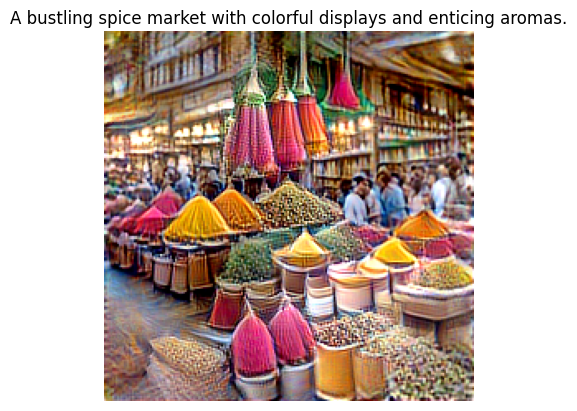

In [61]:
import torch
import yaml
from PIL import Image
import open_clip
import random
import numpy as np
torch.backends.cudnn.benchmark = True


target_text = "A bustling spice market with colorful displays and enticing aromas." #@param {"type": "string"}
seed = 2705 #@param {"type": "integer"}
rejection = 0 #@param {"type": "number"}
num_views = 32 #@param {"type": "integer"}
num_patches = 32 #@param {"type": "integer"}

seed = seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


config = {
    # Losses
    'lambda_clip_loss': 1.0,
    'lambda_patch_loss': 5.0,
    # Optimization
    'num_steps': 100,
    'lr': 0.0175,
    'clip_grad_norm': 0.001,
    # Method
    'patch_size': 128,
    'to_norm': True,
    'thresholding': 0.95, #
    # DiffAug
    'policy': 'color,translation,resize,cutout',
    'device': "cuda",
    'aug': 'diff',
}

sum_loss = 0
config['target_text'] = target_text
config['seed'] = seed
config['rejection'] = rejection
config['num_views'] = num_views
config['num_patches'] = num_patches

with torch.cuda.amp.autocast():
    output_arr, loss = generate(model=model, tokenizer=tokenizer, config=config)

# post process image
img = np.array(output_arr[-1].mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:, :, :]
img = np.transpose(img, (1, 2, 0))

# plot image
plt.figure()
plt.title(target_text)
plt.imshow(img)
plt.axis('off')
plt.show()